# Final Project (Team3)

This project aims to figure out unique patterns of crime incidents in Washington DC by visualizing spatial representations on a map and analyzing geographical attributes.

<font color='#6EB800'>*Reference: Reading Data (GDB, Raw datasets)*</font>

1. All ArcPy(code) and ArcGIS analysis were worked on Apporto. (So path was also set using the path). But, for the case of testing a code on S drive, an absolute path of S drive was additionally added.

2-1. All raw datasets downloaded on Web were stored on 'Data_update' Folder.
   -  In Part 3, code to generate new Features could be tested. 
   
2-2. Two GDB and one Mapfile were submitted. 
   - In Part 2, MyProject_pre.gdb (an inititial GDB as a result of Part 1) could be tested. (works on ArcGIS were decribed as comments) 
   - In Part 4, works to make Final GDB (saved as MyProject.gdb) were described (codes were commented out)
   - In part 5, code to perform '1.Interactive Analysis (KDE)' could be tested on the temporal Map file (Final_Project_Team3_Map_bf_KDE.mapx)
   - Codes to make '2. Explore Proximity feature' were commented out (already updated on GDB)

2-3. Final Map file (used to make report) was submitted as 'Final_Project_Team3_Map.mapx'.

In [4]:
import os
print(os.getcwd())

\\apporto.com\dfs\GWU\Users\nanminwoo_gwu\Desktop


## Part Ⅰ. [WEB] Download Raw data 

- All datasets were gathered from [Open Data DC](https://opendata.dc.gov/explore?collection=Dataset) and preprocessed. 

- There are THREE types of specific datasets that were used in this project
1. CRIME INCIDENTS (5 years: ‘19~23): *.Shp, *CSV
2. Properties(13: Schools, Gas station, etc.): *.Shp
3. Census Economic Characteristics(78 Statistics): *.Shp

## Part Ⅱ. [ArcPro] Make Initial GDB- 'MyProject_pre.gdb'

  - Batch Import (or add feature) *.shp files
  - Show Featrues in the Map, Edit Point Symbology 
  - Arcpy: SET GDB Environment, Make KDE, etc <br>

### 1. Verify GDB 

**Below code is to verify GDB which was generated on ArcPro**
`arcpy.env.workspace` was set to the path for `MyProject_pre.gdb`.

In [2]:
import arcpy

In [70]:
path = r'.\MyProject_pre.gdb'  
#When using S drive Path
#path = r'S:\DATS_6450.81_Topics_in_Data_Science_202303\Woo,Nammin-NWoo\GIS1_Team_3_Submission\MyProject_pre.gdb'
arcpy.env.workspace = (path)
arcpy.overwriteOutput = True

In [71]:
# Check Feature classes
fc_list = arcpy.ListFeatureClasses()
print(fc_list)

['Crime_Incidents_in_2023_kml_point', 'Crime_Incidents_in_2023_shp', 'Census_Economic_shp', 'Census_Economic_kml_Polygons', 'Bank_Locations', 'Farmers_Market_Locations', 'Gas_Stations', 'Grocery_Store_Locations', 'Hospitals', 'Hotels', 'Liquor_Licenses', 'Metro_Station_Entrances_in_DC', 'National_Parks', 'Roads', 'Shopping_Centers', 'Sidewalk_Cafe', 'Crime_Incidents_in_2022', 'Crime_Incidents_in_2021', 'Crime_Incidents_in_2020', 'Crime_Incidents_in_2019', 'DC_Public_Schools']


### 2. Census_Economic Feature class
  
   - Basic Check: descrie, field, row counts, samples

In [76]:
desc2 = arcpy.Describe("Census_Economic_shp")
#desc2 

In [73]:
for fld in desc2.fields:
    #    print("\t" + fld.name)
    print(f"{fld.name} : {fld.Type}")

# Number of record: GetCount : 206 Census Track Areas
count = arcpy.GetCount_management('Census_Economic_shp')
print(f"Name: Census_Econmic_variales, feature count: {count}")

OBJECTID_1 : OID
Shape : Geometry
OBJECTID : SmallInteger
STATEFP : String
COUNTYFP : String
TRACTCE : String
GEOID : String
NAME : String
ALAND : Integer
AWATER : Integer
INTPTLAT : String
INTPTLON : String
DP03_0001E : SmallInteger
DP03_0002E : SmallInteger
DP03_0003E : SmallInteger
DP03_0004E : SmallInteger
DP03_0005E : SmallInteger
DP03_0006E : SmallInteger
DP03_0007E : SmallInteger
DP03_0008E : SmallInteger
DP03_0009P : Double
DP03_0010E : SmallInteger
DP03_0011E : SmallInteger
DP03_0012E : SmallInteger
DP03_0013E : SmallInteger
DP03_0014E : SmallInteger
DP03_0015E : SmallInteger
DP03_0016E : SmallInteger
DP03_0017E : SmallInteger
DP03_0018E : SmallInteger
DP03_0019E : SmallInteger
DP03_0020E : SmallInteger
DP03_0021E : SmallInteger
DP03_0022E : SmallInteger
DP03_0023E : SmallInteger
DP03_0024E : SmallInteger
DP03_0025E : Double
DP03_0026E : SmallInteger
DP03_0027E : SmallInteger
DP03_0028E : SmallInteger
DP03_0029E : SmallInteger
DP03_0030E : SmallInteger
DP03_0031E : SmallIntege

In [75]:
# Check the sample: DP03_0009PE (truncated:DP03_0009P): unemployment_rate, DP03_0119PE(DP03_0119P): pct_all_families_below_poverty
from arcpy.da import *
with arcpy.da.SearchCursor("Census_Economic_shp", ("DP03_0009P", "DP03_0119P")) as cursor:
    i = 0
    for val in cursor:
        if i < 5:
            print(f'Unemployment(%): {val[0]}')
            print(f'Poverty(%): {val[1]}')
            i += 1
        else:
            # Add your desired action here when i reaches 5 or more
            print("Reached 5 iterations. Do something else here.")
            break 

Unemployment(%): 7.3
Poverty(%): 0.5
Unemployment(%): 2.2
Poverty(%): 2.7
Unemployment(%): 14.0
Poverty(%): 23.6
Unemployment(%): 40.0
Poverty(%): 35.5
Unemployment(%): 13.9
Poverty(%): 12.4
Reached 5 iterations. Do something else here.


## Part Ⅲ. Generate New Features

 - To enrich attributes of crime incidents, a feature engineering was performed as follows. 
 - In this stage, CRIME INCIDENTS.CSV (Same data but *.CSV format) was additionally used. (Because Timestamp variables were truncked in *.Shp)
 - Six features were generated as below.
 - **The subsequent analysis will rely on an aggregated data frame, specifically a feature class within the GDB, encompassing five years' worth of crime incidents.**  
  
> *1. Crime_Type: Recategorized as 4 types* 
>   *(Theft, Other_Property_Crimes, Robbery, Other_Violent_Crimes)* 
> 
> *2. Clear_Time: Time to clear a crime incident(Minutes)*
>   *(END_DATE - START_DATE)*
> 
> *3. Pandemic Phase: 3 Phases*
>   *(Before: 2019.1~2020.2, Lockdown: 2020.3.~ 2021.7, Post: 2021.8~2323.12)* 
> 
> *4. Season: Spring,Summer,Fall,Winter*
> 
> *5. Date Phase: 1: 'Beginning', 2: 'Middle', 3: 'End'*
> 
> *6. Time hour: 0~23*

In [1]:
# Read CRIME INCIDENTS (*.CSV) dataset from 2019~2023
path = r'.\Data_update\Crime Raw data(openDC)_CSV'  
#When using S drive Path
#path = r'S:\DATS_6450.81_Topics_in_Data_Science_202303\Woo,Nammin-NWoo\GIS1_Team_3_Submission\Data_update\Crime Raw data(openDC)_CSV'

import pandas as pd
import os
for filename in os.listdir(path):
    if filename.endswith('.csv'):
        filepath = os.path.join(path, filename)
        df_name = filename.split('.')[0]
        year = df_name[-4:]
        globals()[df_name]= pd.read_csv(filepath)
        globals()[df_name]['Year'] = year # Add year column to distinguish
        print(f'Shape of {df_name}: {globals()[df_name].shape}')

Shape of Crime_Incidents_in_2019: (33950, 26)
Shape of Crime_Incidents_in_2020: (27917, 26)
Shape of Crime_Incidents_in_2021: (28348, 26)
Shape of Crime_Incidents_in_2022: (27211, 26)
Shape of Crime_Incidents_in_2023: (26022, 26)


In [2]:
# Merge 5 years
# List of dataframes
dfs = [Crime_Incidents_in_2019, Crime_Incidents_in_2020, Crime_Incidents_in_2021, Crime_Incidents_in_2022, Crime_Incidents_in_2023]
Crime_Incidents_19_23 = pd.concat(dfs, ignore_index=True)
Crime_Incidents_19_23.shape

(143448, 26)

In [3]:
# Verify PK of dataset
pk = ['CCN']  #PK is OBJECTID but it change whenever download it 
temp = Crime_Incidents_19_23.drop_duplicates(subset=pk)
print(f'# of records Before Clean: {Crime_Incidents_19_23.shape[0]}\n After Clean: {temp.shape[0]}')

# of records Before Clean: 143448
 After Clean: 143384


In [4]:
import copy
df = copy.deepcopy(temp) # will use CCN dup dropped 

# 1. Crime_Type:  4 types (Theft, Other_Property_Crimes, Robbery, Other_Violent_Crimes)  
crime_type_map = {'THEFT F/AUTO': 'Theft', 'THEFT/OTHER': 'Theft'
                  , 'ARSON': 'Other_Property_Crimes', 'BURGLARY': 'Other_Property_Crimes', 'MOTOR VEHICLE THEFT': 'Other_Property_Crimes', 'ROBBERY': 'Robbery'
                  , 'ASSAULT W/DANGEROUS WEAPON':'Other_Violent_Crimes'
                  , 'HOMICIDE':'Other_Violent_Crimes', 'SEX ABUSE':'Other_Violent_Crimes'}

df['Crime_Type'] = df['OFFENSE']
df['Crime_Type'] = df['Crime_Type'].map(crime_type_map)

# 2. Clear_Time: END_DATE - START_DATE(Minutes), Time to clear a crime incident
df['START_DATE'] = pd.to_datetime(df['START_DATE'])
df['END_DATE'] = pd.to_datetime(df['END_DATE'])
df['Clear_Time'] = round((df['END_DATE'] - df['START_DATE']).dt.total_seconds() / 60,1)

# 3. Pandemic Phase: (Before: 2019.1~2020.2, Lockdown: 2020.3.~ 2021.7, Post: 2021.8~2323.12) 
df['REPORT_DAT'] = pd.to_datetime(df['REPORT_DAT'])
df['Pandemic_Phase'] = pd.cut(df['REPORT_DAT'],
                               bins=[pd.Timestamp('2019-01-01'), pd.Timestamp('2020-03-01')
                                     , pd.Timestamp('2021-08-01'), pd.Timestamp('2024-01-01')],
                               labels=['Before', 'Lockdown', 'Post'])

# 4. Season: Spring,Summer,Fall,Winter
df['Season'] = df['REPORT_DAT'].dt.month % 12 // 3 + 1
df['Season'] = df['Season'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'})

# 5. Date Phase: 1: 'Beginning', 2: 'Middle', 3: 'End'
df['Date_Phase'] = df['REPORT_DAT'].dt.day // 10 + 1
df['Date_Phase'] = df['Date_Phase'].map({1: 'Beginning', 2: 'Middle', 3: 'End'})

# 6. Time hour: 0~23
df['Time_Hour'] = df['START_DATE'].dt.hour
df.dtypes

X                                   float64
Y                                   float64
CCN                                   int64
REPORT_DAT              datetime64[ns, UTC]
SHIFT                                object
METHOD                               object
OFFENSE                              object
BLOCK                                object
XBLOCK                              float64
YBLOCK                              float64
WARD                                float64
ANC                                  object
DISTRICT                            float64
PSA                                 float64
NEIGHBORHOOD_CLUSTER                 object
BLOCK_GROUP                          object
CENSUS_TRACT                        float64
VOTING_PRECINCT                      object
LATITUDE                            float64
LONGITUDE                           float64
BID                                  object
START_DATE              datetime64[ns, UTC]
END_DATE                datetime

In [11]:
col = ['LATITUDE','LONGITUDE','DISTRICT','CENSUS_TRACT','Clear_Time','Crime_Type','Pandemic_Phase','Season','Date_Phase']
df[col].head()

,LATITUDE,LONGITUDE,DISTRICT,CENSUS_TRACT,Clear_Time,Crime_Type,Pandemic_Phase,Season,Date_Phase
0,38.896122,-77.010245,1.0,5900.0,2.8,Theft,Before,Spring,Middle
1,38.867982,-76.981735,6.0,7605.0,32.8,Theft,Before,Spring,Middle
2,38.910584,-77.065019,2.0,102.0,4.8,Theft,Before,Spring,Middle
3,38.957795,-77.001698,4.0,9505.0,NaN,Theft,Before,Spring,Beginning
4,38.885835,-76.929379,6.0,9904.0,49.8,Robbery,Before,Spring,Beginning


In [ ]:
col = ['LATITUDE','LONGITUDE','DISTRICT','CENSUS_TRACT','Clear_Time','Crime_Type','Pandemic_Phase','Season','Date_Phase']
df[col].head()

In [14]:
df[col].describe(include = 'all')

,LATITUDE,LONGITUDE,DISTRICT,CENSUS_TRACT,Clear_Time,Crime_Type,Pandemic_Phase,Season,Date_Phase
count,143384.000000,143384.000000,142971.000000,143366.000000,1.284570e+05,143384,143384,143384,136389
unique,NaN,NaN,NaN,NaN,NaN,4,3,4,3
top,NaN,NaN,NaN,NaN,NaN,Theft,Post,Summer,End
freq,NaN,NaN,NaN,NaN,NaN,99349,66314,40637,47279
mean,38.907728,-77.008253,3.680935,7893.363936,2.678716e+03,NaN,NaN,NaN,NaN
std,0.029832,0.035288,1.852817,39346.166624,1.473507e+05,NaN,NaN,NaN,NaN
min,38.813473,-77.114139,1.000000,101.000000,-6.000000e+01,NaN,NaN,NaN,NaN
25%,38.894473,-77.031559,2.000000,3702.000000,1.860000e+01,NaN,NaN,NaN,NaN
50%,38.907360,-77.012149,3.000000,7202.000000,6.500000e+01,NaN,NaN,NaN,NaN
75%,38.924468,-76.986516,5.000000,9102.000000,3.542000e+02,NaN,NaN,NaN,NaN


In [6]:
df['Crime_Type'].value_counts()

Theft                    99349
Other_Property_Crimes    23890
Robbery                  11009
Other_Violent_Crimes      9136
Name: Crime_Type, dtype: int64

In [7]:
df['Pandemic_Phase'].value_counts()

Post        66314
Before      39412
Lockdown    37658
Name: Pandemic_Phase, dtype: int64

In [8]:
import pandas as pe
pd.crosstab(df.Pandemic_Phase,df.Crime_Type)
#pd.crosstab(w1.education,w1.income00, normalize='index').mul(100).round(1)

Crime_Type,Other_Property_Crimes,Other_Violent_Crimes,Robbery,Theft
Pandemic_Phase,,,,
Before,4040,2216,2535,30621
Lockdown,6656,2809,2732,25461
Post,13194,4111,5742,43267


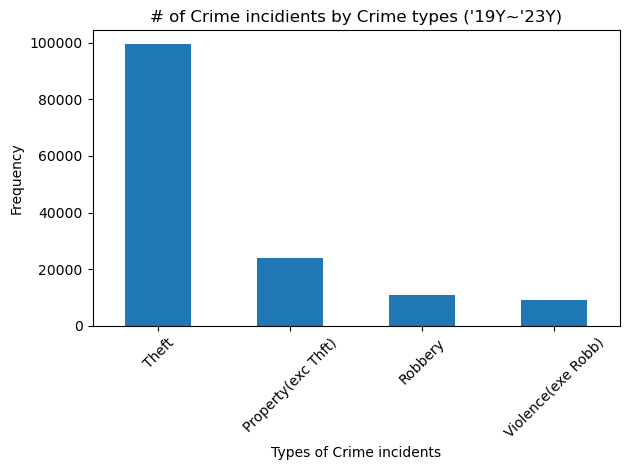

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Get the value counts
counts = df['Crime_Type'].value_counts()
# Replace the index with your new labels
counts.index = ['Theft', 'Property(exc Thft)', 'Robbery', 'Violence(exe Robb)']
ax =  counts.plot(kind='bar',legend=False)
ax.set_xlabel('Types of Crime incidents') # 
ax.set_ylabel('Frequency')
plt.xticks(rotation=45) # horizontal 
plt.title("# of Crime incidients by Crime types ('19Y~'23Y)")
plt.tight_layout()
#plt.show()
# Save the plot
plt.savefig(f'Crime_Type_all_periods.jpg')

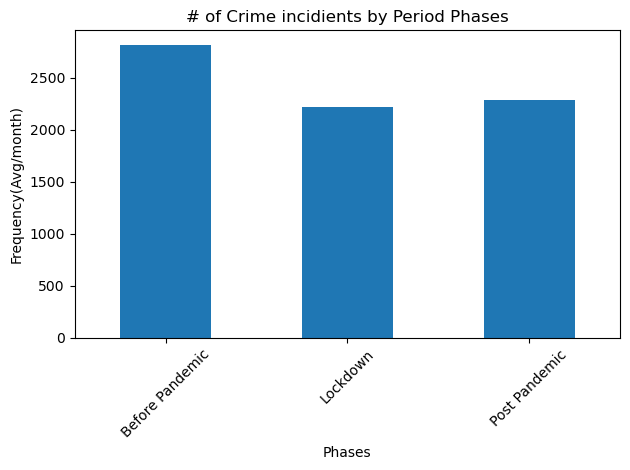

In [18]:
# Get the value counts
counts = df['Pandemic_Phase'].value_counts().sort_index()
# avg/a month.
counts[0] = (counts[0]/14).astype(int)
counts[1] = (counts[1]/17).astype(int)
counts[2] = (counts[2]/29).astype(int)
# Replace the index with your new labels
counts.index = ['Before Pandemic', 'Lockdown', 'Post Pandemic']
ax =  counts.plot(kind='bar',legend=False)
ax.set_xlabel('Phases') # 
ax.set_ylabel('Frequency(Avg/month)')
plt.xticks(rotation=45) # horizontal 
plt.title("# of Crime incidients by Period Phases")
plt.tight_layout()
#plt.show()
# Save the plot
plt.savefig(f'Pandemic_Phase_all_periods.jpg')

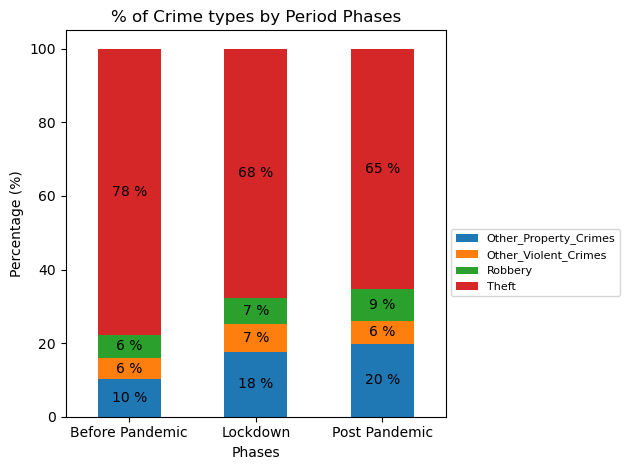

In [65]:
# Calculate the counts of 'Pandemic_Phase' and 'Crime_Type'
counts = df.groupby(['Pandemic_Phase', 'Crime_Type']).size().unstack()

# Normalize the counts to get percentages
counts = (counts.div(counts.sum(axis=1), axis=0) * 100).sort_index()
#print(counts)
# Replace the index with your new labels
counts.index = ['Before Pandemic', 'Lockdown', 'Post Pandemic']

# Plot the stacked bar chart
ax = counts.plot(kind='bar', stacked=True, legend=True)
ax.set_xlabel('Phases')
ax.set_ylabel('Percentage (%)')
ax.legend(loc='best', bbox_to_anchor=(1, 0.5), prop={'size': 8})
plt.xticks(rotation=0) # horizontal 
plt.title(r"% of Crime types by Period Phases")
plt.tight_layout()

# Add annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.0f} %'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')

#plt.show()
# Save the plot
plt.savefig('Crime_types_by_Phase.jpg')

###  Export dataframe to CSV 

   * Exported CSV file will be added on the current GDB  

In [12]:
#print(Crime_Incidents_19_23.shape, df.shape)
#
feat = ['CCN','Year', 'Crime_Type', 'Clear_Time', 'Pandemic_Phase', 'Season', 'Date_Phase', 'Time_Hour'] 
# PK+ add features: 
df.to_csv(os.path.join(os.getcwd(),'Crime_Incidents_19_23_add_feat_all.csv'))
#df[feat].to_csv(os.path.join(os.getcwd(),'Crime_Incidents_19_23_add_feat.csv'))

## Part Ⅳ. [ArcPro] Make Final GDB - 'MyProject.gdb'

  - New features (Part Ⅲ) were updated to the current GDB (MyProject_pre.gdb)
  - Merged previous 5 year Crime incidents features(based on Shapefiles) into 1 feature (Ready to Analysis)
  - **Final GDB was saved as MyProject.gdb**
  - *Feature class "Crime_Incidents_19_23_Merged_CSV" will be mainly used in upcoming analysis*

In [ ]:
# 1) Aggregate current features based on Shapefiles 
# List of Crime shapefiles in current GDB
feature_classes = ['Crime_Incidents_in_2019', 'Crime_Incidents_in_2020', 'Crime_Incidents_in_2021', 'Crime_Incidents_in_2022', 'Crime_Incidents_in_2023_shp']  #2023: test(kml,shp,etc)

# [Finished] Define Output merged feature class 
# out_feature_class = "Crime_Incidents_19_23_Merged"
# Used the Merge tool to merge 5 years features (But in memory, Should do Copy to save)
# arcpy.Merge_management(feature_classes, out_feature_class)

In [ ]:
# Check a result, Field names
desc = arcpy.Describe("Crime_Incidents_19_23_Merged")
for fld in desc.fields:
    #    print("\t" + fld.name)
    print(f"{fld.name} : {fld.Type}")
print(df.columns.to_list())  

#### Below code to add new feature to the GDB was commented out 
    
     - All features were already added to the final GDB (MyProject.gdb)

In [14]:
# 2) Make "Crime_Incidents_19_23_Merged_CSV" by importing generated output(Part Ⅲ CSV)

# [Finished] Import the CSV file as a table
#arcpy.TableToTable_conversion("Crime_Incidents_19_23_add_feat_all.csv", arcpy.env.workspace, "crime_19_23_csv")

# [Worked on ArcPro] Converted the table to the Point feature class on ArcPro
# 1. On the Map tab, in the Layer group, click the Add Data drop-down menu, and click XY Point Data.
# 2. Choose a table that contains x,y coordinate data.
# 3. Click the X Field drop-down arrow and click the field containing x-coordinate values.
# 4. Click the Y Field drop-down arrow and click the field containing y-coordinate values.
# 5. Saved Updated GDB as MyProject.gdb

# Alternative trials by arcpy-- 
# arcpy.MakeTableView_management(in_csv, "csv_view_2")
# arcpy.management.XYTableToPoint("csv_view_2", "Crime_Incidents_19_23_Merged_CSV", "X", "Y")
# arcpy.AddJoin_management("Crime_Incidents_19_23_Merged", "CCN", "csv_view_add_feat_f", "CCN")

<Result '.\\MyProject.gdb\\crime_19_23_csv'>

## Part Ⅴ. Analysis 
   
    1. Interactive Analysis to Visualize Crime Hot spots(KDE)
    2. Explore Proximity feature

In [5]:
import arcpy
#path = r'.\MyProject.gdb'
path = r'\\apporto.com\dfs\GWU\Users\nanminwoo_gwu\Desktop\IGSUP_data_student\IGSUP_data_student\@Final Project\MyProject (GDB,ArcPy)\MyProject.gdb'
#When using S drive Path
#path = r'S:\DATS_6450.81_Topics_in_Data_Science_202303\Woo,Nammin-NWoo\GIS1_Team_3_Submission\MyProject.gdb'
arcpy.env.workspace = (path)
arcpy.overwriteOutput = True

In [6]:
fc_list = arcpy.ListFeatureClasses()
print(fc_list)

['Crime_Incidents_in_2023_kml_point', 'Crime_Incidents_in_2023_shp', 'Census_Economic_shp', 'Census_Economic_kml_Polygons', 'Bank_Locations', 'Farmers_Market_Locations', 'Gas_Stations', 'Grocery_Store_Locations', 'Hospitals', 'Hotels', 'Liquor_Licenses', 'Metro_Station_Entrances_in_DC', 'National_Parks', 'Roads', 'Shopping_Centers', 'Sidewalk_Cafe', 'Crime_Incidents_in_2022', 'Crime_Incidents_in_2021', 'Crime_Incidents_in_2020', 'Crime_Incidents_in_2019', 'DC_Public_Schools', 'Crime_Incidents_19_23_Merged', 'Crime_Incidents_19_23_Merged_CSV', 'Crime_Buffer_Bank_Locations', 'Buffer_Properties_Intersect_Bank_Locations', 'Crime_Buffer_Farmers_Market_Locations', 'Buffer_Properties_Intersect_Farmers_Market_Locations', 'Crime_Buffer_Gas_Stations', 'Buffer_Properties_Intersect_Gas_Stations', 'Crime_Buffer_Grocery_Store_Locations', 'Buffer_Properties_Intersect_Grocery_Store_Locations', 'Crime_Buffer_Hospitals', 'Buffer_Properties_Intersect_Hospitals', 'Crime_Buffer_Hotels', 'Buffer_Properties_

### 1. Interactive Analysis to Visualize Crime Hot spots(KDE)

#### Step 1. Basic Check: descrie, field, row counts, samples

In [79]:
desc = arcpy.Describe("Crime_Incidents_19_23_Merged_CSV")
desc

catalogPath,.\MyProject.gdb\Crime_Incidents_19_23_Merged_CSV
dataType,FeatureClass
shapeType,Point
hasM,False
hasZ,False
OBJECTID_1,OID
Shape,Geometry
Field1,Integer
X,Double
Y,Double
CCN,Integer


In [80]:
for fld in desc.fields:
    #    print("\t" + fld.name)
    print(f"{fld.name} : {fld.Type}")

# field_list = arcpy.ListFields("Crime_Incidents_in_2023_shp")
# field_list

OBJECTID_1 : OID
Shape : Geometry
Field1 : Integer
X : Double
Y : Double
CCN : Integer
REPORT_DAT : String
SHIFT : String
METHOD : String
OFFENSE : String
BLOCK : String
XBLOCK : Double
YBLOCK : Double
WARD : Double
ANC : String
DISTRICT : Double
PSA : Double
NEIGHBORHOOD_CLUSTER : String
BLOCK_GROUP : String
CENSUS_TRACT : Double
VOTING_PRECINCT : String
LATITUDE : Double
LONGITUDE : Double
BID : String
START_DATE : String
END_DATE : String
OBJECTID : Integer
OCTO_RECORD_ID : String
Year : Integer
Crime_Type : String
Clear_Time : Double
Pandemic_Phase : String
Season : String
Date_Phase : String
Time_Hour : Double


In [81]:
# Numer of record: GetCount
count = arcpy.GetCount_management('Crime_Incidents_19_23_Merged_CSV')
print(f"Name: Crime incidents(5years), feature count: {count}")

Name: Crime incidents(5years), feature count: 143384


Time stamp variales are truncated. So, they will be manually added after converting into Clearance_time

In [82]:
# Check the sample
from arcpy.da import *
with arcpy.da.SearchCursor("Crime_Incidents_19_23_Merged_CSV", ("START_DATE", "END_DATE")) as cursor:
    i = 0
    for val in cursor:
        if i < 5:
            print(f'START: {val[0]}')
            print(f'END: {val[1]}')
            i += 1
        else:
            # Add your desired action here when i reaches 5 or more
            print("Reached 5 iterations. Do something else here.")
            break 

START: 2019-05-16 23:15:24+00:00
END: 2019-05-16 23:18:13+00:00
START: 2019-05-18 10:31:59+00:00
END: 2019-05-18 11:04:48+00:00
START: 2019-05-18 18:30:47+00:00
END: 2019-05-18 18:35:33+00:00
START: 2019-04-02 23:20:46+00:00
END: None
START: 2019-04-04 05:00:17+00:00
END: 2019-04-04 05:50:06+00:00
Reached 5 iterations. Do something else here.


#### Step 2. Create KDE feature 

- Interactive KDE Plot on ArcGIS by input value as parameter To EXPLORE pattern of Crime  
- Two Input Parameters: Pandemic Phase, Crime Type


#### A. Crime Type
  - 9 types in the original data were grouped as Four types : 
    1. Theft    
    2. Other_Property_Crimes (ARSON, BURGLARY, MOTOR VEHICLE THEFT)
    3. Robbery  
    4. Other_Violent_Crimes (ASSAULT, HOMICIDE, SEX ABUSE)

#### B. Period Phases (Pandemic_Phase)
  - 5 years ('19~'23y) were grouped as Three phases : 
    1. Before: ‘19.1~’20.2(14M)  
    2. Lockdown: ‘20.3.~ ‘21.7(17M) 
    3. Post: ‘21.8~’23.12(29M)

In [7]:
from arcpy.sa import *
arcpy.CheckOutExtension("Spatial")

'CheckedOut'

In [16]:
# Function to display options and get user input
def get_user_input(options, prompt):
    for key, value in options.items():
        print(f"{key}: {value}")
    return options[int(input(prompt))]

# Crime type options
crime_type_list = {1: 'Theft', 2: 'Other_Property_Crimes', 3: 'Robbery', 4: 'Other_Violent_Crimes'}
print("Choose Crime Type:")
crime_type = get_user_input(crime_type_list, "Enter the number of your choice: ")
print(f"Selected Crime Type: {crime_type}")

# Pandemic phase options
phase_type_list = {1: 'Before', 2: 'Lockdown', 3: 'Post'}
print("\nChoose Pandemic Phase Type:")
phase_type = get_user_input(phase_type_list, "Enter the number of your choice: ")
print(f"Selected Pandemic Phase: {phase_type}")

# Create a combined feature layer
out_layers = "Crime_Incidents_19_23_" + crime_type + "_" + phase_type
arcpy.MakeFeatureLayer_management(in_features="Crime_Incidents_19_23_Merged_CSV", out_layer=out_layers)

# Create SQL expression for combined filter
crime_field = arcpy.AddFieldDelimiters(arcpy.env.workspace, "Crime_Type")
phase_field = arcpy.AddFieldDelimiters(arcpy.env.workspace, "Pandemic_Phase")
SQLExp = f"{crime_field} = '{crime_type}' AND {phase_field} = '{phase_type}'"

# Apply combined filter and create KDE
try:
    arcpy.SelectLayerByAttribute_management(in_layer_or_view=out_layers,
                                            selection_type="NEW_SELECTION",
                                            where_clause=SQLExp)

    with arcpy.EnvManager(extent=arcpy.Extent(-77.112318, 38.814667, -76.910140, 38.993573)):
        KDE_layer_name = f"KDE_{crime_type}_{phase_type}"
#         original_kernel_density = KernelDensity(in_features=out_layers,
#                                                   population_field="",
#                                                   cell_size=0.005,
#                                                   search_radius=0.01)
        # (Final) Avg # of incidents per a Month
        # 'Before':14M 'Lockdown': 17M 'Post': 29M
        if phase_type == 'Before': 
            globals()[KDE_layer_name]  = KernelDensity(in_features=out_layers,
                                                   population_field="",
                                                   cell_size=0.005,
                                                   search_radius=0.01) / 12
        elif phase_type == 'Lockdown': 
            globals()[KDE_layer_name]  = KernelDensity(in_features=out_layers,
                                                   population_field="",
                                                   cell_size=0.005,
                                                   search_radius=0.01) / 17
        elif phase_type == 'Post': 
            globals()[KDE_layer_name]  = KernelDensity(in_features=out_layers,
                                                   population_field="",
                                                   cell_size=0.005,
                                                   search_radius=0.01) / 29
            
        print(f"KDE layer created: {KDE_layer_name}")

except arcpy.ExecuteError:
    print(arcpy.GetMessages())

# Clear selection
arcpy.management.SelectLayerByAttribute(out_layers, 'CLEAR_SELECTION')

Choose Crime Type:
1: Theft
2: Other_Property_Crimes
3: Robbery
4: Other_Violent_Crimes
Enter the number of your choice: 1
Selected Crime Type: Theft

Choose Pandemic Phase Type:
1: Before
2: Lockdown
3: Post
Enter the number of your choice: 3
Selected Pandemic Phase: Post
KDE layer created: KDE_Theft_Post


<Result 'Crime_Incidents_19_23_Theft_Post'>

### 2. Explore Proximity feature
 
  - Explore Number of Property near each crime spots (use Buffer analysis within 300 ft)
  - Analysis by Crime types Whether which properties are relatively higher probability of existence in a certain crime type 

In [3]:
out_layers = "Crime_Incidents_19_23_buffer"
arcpy.MakeFeatureLayer_management(in_features="Crime_Incidents_19_23_Merged_CSV"
                                  , out_layer=out_layers)

<Result 'Crime_Incidents_19_23_buffer'>

In [4]:
import pandas as pd
properties_list = ['Bank_Locations','Farmers_Market_Locations','Gas_Stations','Grocery_Store_Locations','Hospitals','Hotels','Liquor_Licenses','Metro_Station_Entrances_in_DC','National_Parks','Shopping_Centers','Sidewalk_Cafe','DC_Public_Schools']
buffer_distance = "300 Feet"  #100m
print(f'Basic infomation of Proximity Analysis:\n 1. # of Properties to check: {len(properties_list)} \n 2. Distance(buffer area): {buffer_distance}')

# Initialize the result dataframe
result_df = None
print(result_df)

Basic infomation of Proximity Analysis:
 1. # of Properties to check: 12 
 2. Distance(buffer area): 300 Feet
None


#### Below code to make Feature class and Table was commented out 
    
     - All features were already added to the final GDB (MyProject.gdb)

In [5]:
# # Iterate over each property
# for property_fc in properties_list:
#     # Create a buffer around each crime incident
#     crime_buffer_fc = "Crime_Buffer_" + property_fc
#     arcpy.Buffer_analysis("Crime_Incidents_19_23_buffer", crime_buffer_fc, buffer_distance)

#     # Intersect the buffer with the properties to find properties within the buffer
#     buffer_properties_intersect = "Buffer_Properties_Intersect_"+ property_fc
#     arcpy.Intersect_analysis([crime_buffer_fc, property_fc], buffer_properties_intersect)

#     # Use a SearchCursor to iterate through the buffer polygons and count the number of intersecting properties
#     # Initialize a dictionary to hold the count of properties for each crime type
#     crime_property_count = {}

#     # Assuming 'Crime_Type' is the crime type and 'OBJECTID' is the unique identifier for the properties
#     with arcpy.da.SearchCursor(buffer_properties_intersect, ['Crime_Type', 'OBJECTID']) as cursor:
#         for row in cursor:
#             # Count the number of properties for each crime type
#             crime_type = row[0]
#             crime_property_count[crime_type] = crime_property_count.get(crime_type, 0) + 1

#     # Now you can use 'crime_property_count' dictionary where keys are crime types and values are the count of properties
#     # Convert the dictionary to a dataframe
#     property_df = pd.DataFrame.from_dict(crime_property_count, orient='index', columns=[property_fc])
#     property_df.reset_index(inplace=True)
#     property_df.rename(columns={'index': 'Crime_Type'}, inplace=True)

#     # Merge the result to the main dataframe
#     if result_df is None:
#         result_df = property_df
#     else:
#         result_df = pd.merge(result_df, property_df, on='Crime_Type', how='outer')

# # Fill NaN values with 0 (representing no property)
# result_df.fillna(0, inplace=True)

# print(result_df)

              Crime_Type  Bank_Locations  Farmers_Market_Locations  \
0                Robbery             633                       111   
1  Other_Property_Crimes            1325                       217   
2                  Theft           11216                      1594   
3   Other_Violent_Crimes             444                        68   

   Gas_Stations  Grocery_Store_Locations  Hospitals  Hotels  Liquor_Licenses  \
0           403                      233          9     267             7258   
1           576                      507         13     703            14963   
2          3216                     5624        101    5653           102478   
3           315                      166          9     191             4490   

   Metro_Station_Entrances_in_DC  National_Parks  Shopping_Centers  \
0                             90            4664                86   
1                             76            9083               201   
2                           1739      

In [7]:
# import copy
# temp = copy.deepcopy(result_df)
# temp2 = temp.T
#temp2.to_csv('Proximity_feature_result.csv')